### Text Classification with various embedding
12/24/2020 Thu  
- nlp preprocessing 
    - Tokenize, removing stop words, stemming, lemmatization 
- Model
    - Bag of words(tf-idf)
    - Word2Vec
    - Bert
    
- Reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk


### Read Data

In [3]:
# read data
reuters_train = pd.read_csv('result/reuters_final_train.csv')
reuters_test = pd.read_csv('result/reuters_final_test.csv')

In [4]:
# drop nan
reuters_train = reuters_train.dropna()
reuters_test = reuters_test.dropna()

In [5]:
reuters_train.head()

,id,topics,texts
0,4005,interest,u.s. economic data key to debt futures outlook...
1,4005,retail,u.s. economic data key to debt futures outlook...
2,4005,ipi,u.s. economic data key to debt futures outlook...
3,4012,earn,bank of british columbia 1st qtr jan 31 netope...
4,4014,earn,restaurant associates inc <ra> 4th qtr jan 3sh...


### Statistics

In [64]:
# topic frequency
topics_frequency = reuters_train.groupby(['topics'])['texts'].count().sort_values(ascending = False)


The number of topics: 16.


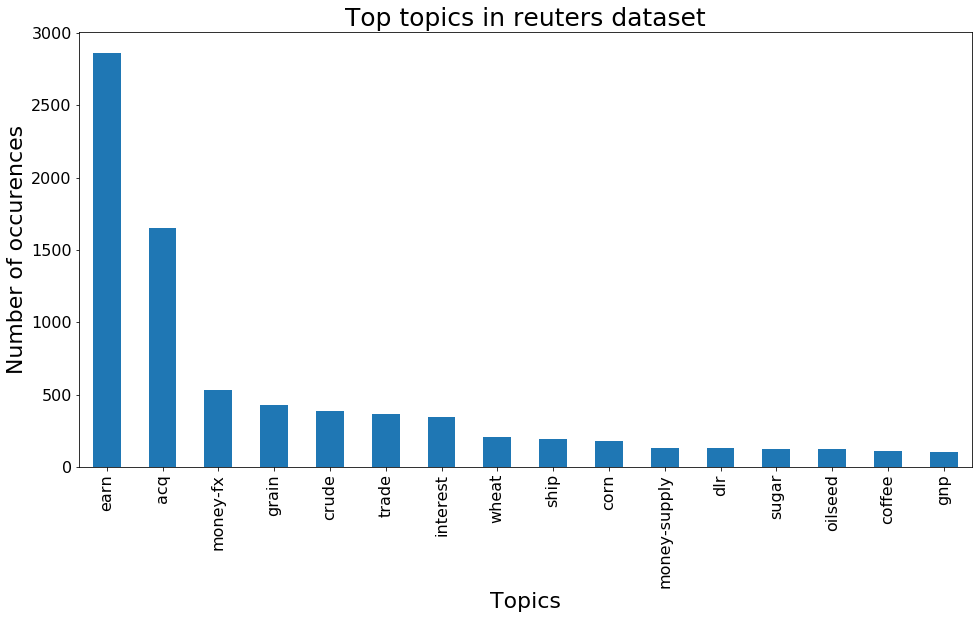

In [73]:
top_topics = topics_frequency[topics_frequency>100]
print("The number of topics: {}.".format(len(top_topics)))
fig, ax = plt.subplots(figsize=(16,8))
params = {'axes.labelsize': 22,
          'axes.titlesize': 25,
          'xtick.labelsize':16,
          'ytick.labelsize':16
         }


top_topics.plot.bar()
ax.set_title('Top topics in reuters dataset');
ax.set_xlabel('Topics');
ax.set_ylabel('Number of occurences');

plt.rcParams.update(params)
plt.show()

In [81]:
topics_frequency[:10].keys()

Index(['earn', 'acq', 'money-fx', 'grain', 'crude', 'trade', 'interest',
       'wheat', 'ship', 'corn'],
      dtype='object', name='topics')

### NLP Preprocess

In [2]:
stopwords = nltk.corpus.stopwords.words("english")
porterstem = nltk.stem.porter.PorterStemmer()
lemmatization = nltk.stem.wordnet.WordNetLemmatizer()

def nlp_preprocess(text):
    # convert to lowercase and remove punctuations and characters and strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize 
    tokens = text.split()
    
    # Remove Stopwords
    tokens = [word for word in tokens if word not in stopwords]
                
    # Stemming
    tokens = [porterstem.stem(word) for word in tokens]
                
    # lemmatization
    tokens = [lemmatization.lemmatize(word) for word in tokens]
    
    text = " ".join(tokens)
    return text

In [7]:
reuters_train['texts_clean'] = reuters_train['texts'].apply(lambda x:nlp_preprocess(x))
reuters_test['texts_clean'] = reuters_test['texts'].apply(lambda x:nlp_preprocess(x))


In [25]:
reuters_train.head()

,id,topics,texts,texts_clean
0,4005,interest,u.s. economic data key to debt futures outlook...,u econom data key debt futur outlooku econom d...
1,4005,retail,u.s. economic data key to debt futures outlook...,u econom data key debt futur outlooku econom d...
2,4005,ipi,u.s. economic data key to debt futures outlook...,u econom data key debt futur outlooku econom d...
3,4012,earn,bank of british columbia 1st qtr jan 31 netope...,bank british columbia 1st qtr jan 31 netop shr...
4,4014,earn,restaurant associates inc <ra> 4th qtr jan 3sh...,restaur associ inc ra 4th qtr jan 3shr 25 ct v...


### Bag of Words

In [8]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

In [42]:
# vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,2))
vectorizer = feature_extraction.text.TfidfVectorizer()
vectorizer.fit(reuters_train['texts_clean'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [47]:
vector_reuters_train = vectorizer.transform(reuters_train['texts_clean'])
print("The shape of reuters training data: {}.".format(vector_reuters_train.shape))

(9592, 76928)

Text(0.5, 1, 'Sparse Matrix Sample')

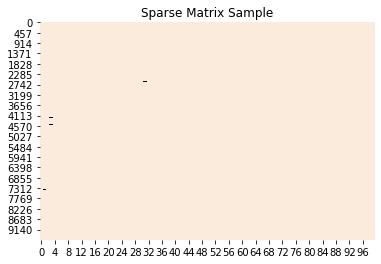

In [19]:
# Heatmap
sns.heatmap(vector_reuters_train.todense()[:,np.random.randint(0,vector_reuters_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')


In [45]:
dic_vocabulary = vectorizer.vocabulary_

In [46]:
dic_vocabulary['week']

74463

Feature selection based on Chi-Square  
 chi-square test measures **dependence between stochastic variables**  

- treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others);
- perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
- keep only the features with a certain p-value from the Chi-Square test.


In [28]:
from sklearn import feature_selection

In [48]:
topics_train = reuters_train['topics']
reuters_train_names = vectorizer.get_feature_names()
p_value = 0.95

new_reuters_train = pd.DataFrame()
for topic in np.unique(topics_train):
    chi2, p = feature_selection.chi2(vector_reuters_train, topics_train==topic)
    new_reuters_train = new_reuters_train.append(pd.DataFrame({"feature":reuters_train_names, "score":1-p, "topics":topic}))
    new_reuters_train = new_reuters_train.sort_values(["topics","score"], 
                    ascending=[True,False])
    new_reuters_train = new_reuters_train[new_reuters_train["score"]>p_value]
    
    
reuters_train_names = new_reuters_train["feature"].unique().tolist() 

print("The shape of new reuters dataframe: {}.".format(new_reuters_train.shape))


The shape of new reuters dataframe: (39402, 3).


In [51]:
print("Total topics: {}".format(len(np.unique(topics_train))))
for topic in np.unique(topics_train):
    print("# {}:".format(topic))
    print("  . selected features:",len(new_reuters_train[new_reuters_train["topics"]==topic]))
    print("  . top features:", ",".join(new_reuters_train[new_reuters_train["topics"]==topic]["feature"].values[:10]))
    print(" ")
    break

Total topics: 114
# acq:
  . selected features: 727
  . top features: acquir,acquisit,complet,ct,cyclop,merger,offer,share,stake,usair
 


In [52]:
# Refit data with select features
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=reuters_train_names)
vectorizer.fit(reuters_train['texts_clean'])
vector_reuters_train = vectorizer.transform(reuters_train['texts_clean'])


In [53]:
vector_reuters_train.shape

(9592, 28554)